In [1]:
%load_ext lab_black
%load_ext autotime

import drnb.embed.pipeline as pl

time: 7.77 s (started: 2022-11-20 15:03:12 -08:00)


UMAP uses a spectral embedding for initialization: it's very close to being a Laplacian Eigenmap using the UMAP fuzzy simplicial set as the input sparse graph (the fuzzy set membership values being the weight of the edges between vertices). [Linderman and Steinerberger](https://arxiv.org/abs/1706.02582) suggested a connection between spectral clustering and the early exaggeration phase of t-SNE, so this turns out to be quite a good way to initialize an embedding, certainly better than random initialization. Also, compared to PCA-based approaches, this has the feature of being consistent with the rest of the embedding, as it's not using any more information than the optimization step uses. That could be seen as a downside as PCA effectively uses more of the data but:

* Using PCA doesn't make a lot of sense for non-Euclidean metrics. Maybe cosine is also ok given the monotonic relationship between the cosine distance and the Euclidean distance between normalized vectors.
* Using PCA enforces a global view of the data. This is not necessarily a bad thing, but you don't get to control the trade-off of local to global emphasis the initialization uses. For manifolds like the swiss roll, PCA will give you back the folded up form, which is much harder to unroll compared to the spectral initialization.
* You need the initial data around, not just the input graph.

So it's nice to have a principled way to initialize the embedding which can make use of the graph data that is already on hand. The main drawback with spectral initialization is that it can be a bit erratic. Fundamental to the solution is finding eigenvectors of a sparse and potential large matrix. If the matrix is not well-conditioned, then the solvers can fail. Worse, they can hang for unspecified amounts of time if things are going really badly. Disconnected components or close-to-disconnected components can be the cause of this, for which UMAP is at an elevated risk due to the default low number of nearest neighbors it calculates compared to e.g. t-SNE. But also well-connected graphs can cause the solvers problems if the underlying manifold has a high "aspect ratio", i.e. one of the axes has a large extent compared to the other axis. Points arranged along a line are a good example of a nightmare scenario for a spectral method. This aspect of spectral methods was first described by [Goldberg and co-workers](https://arxiv.org/abs/0806.2646). In general, this also means that structured low-dimensional manifolds that are often used as synthetic datasets to test dimensionality reduction can be misleading. For example, the mammoth dataset is much harder to generate a spectral embedding for compared to MNIST, despite mammoth having fewer items in it. For real-world data which tends to be messy and blobby, this isn't much of an issue, but there are some datasets like `tomoradar` which have problems.

I attempted to tweak the parameters of the ARPACK-based [`eigsh`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html) solver used by UMAP to see if there was much that could be done, but that was rather difficult. An alternative strategy is to use truncated SVD to generate a rough initial guess to the eigenvectors (there is a [straightforward relationship](https://jlmelville.github.io/smallvis/spectral.html#Connection_Between_SVD_and_Spectral_Decomposition) between the singular vectors of the normalized symmetric graph Laplacian and the eigenvectors) and then feed that initial guess to the [`lobpcg`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lobpcg.html) solver. See [this PR](https://github.com/lmcinnes/umap/pull/924) for more details.

Using just the UMAP spectral initialization as an embedding method can be achieved with the `umapspectral` embedder. Some parameters:

* `n_neighbors` -- number of nearest neighbors to generate for the graph.
* `tsvdw` -- if `True`, use the truncated SVD "warmed" initialization with lobpcg as the solver. If `False` (the default), use `eigsh` as UMAP does internally.
* `tsvdw_tol` -- the tolerance for the `tsvdw` solver. Ignored if `tsvdw=False`. Default is `1e-5`, but you can probably get away with `1e-4` for most datasets.
* `jitter` -- if `True` (the default), the returned result is scaled and some noise added to the coordinates which is part of the typical UMAP initialization procedure. This should help avoid getting the result stuck in local minima when used for downstream optimization.

## Testing Some Parameters

Let's see what the effect of the tsvd-warmed initialization is and whether jittering has any particular visual effect.

In [17]:
eigsh_jitter = pl.create_pipeline(
    method=pl.embedder("umapspectral", params=dict(tsvdw=False, tsvdw_jitter=False)),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
)

eigsh_no_jitter = pl.create_pipeline(
    method=pl.embedder("umapspectral", params=dict(tsvdw=False, tsvdw_jitter=False)),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
)

tsvdw_jitter = pl.create_pipeline(
    method=pl.embedder("umapspectral", params=dict(tsvdw=True, tsvdw_jitter=True)),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
)

tsvdw_no_jitter = pl.create_pipeline(
    method=pl.embedder("umapspectral", params=dict(tsvdw=True, tsvdw_jitter=False)),
    eval_metrics=["rte", "rpc", ("nnp", dict(n_neighbors=[15, 50, 150]))],
)

time: 7.91 ms (started: 2022-11-20 15:16:31 -08:00)


Testing results for 3 datasets below, I use `s1k` and `mnist` to represent typical datasets with a set of clusters in them, and then `mammoth` for a more difficult structured case. From the results:

* Visually, there is not a lot to choose between any of the settings. Biggest visual difference is for `mammoth`.
* All the evaluation metrics are basically the same for all the settings.
* For `mammoth`, using the tsvd-warmed solver is noticeably quicker. Bear in mind some of the run time is from the evaluations, but there is a still a detectable difference compared to `mnist`.

### s1k

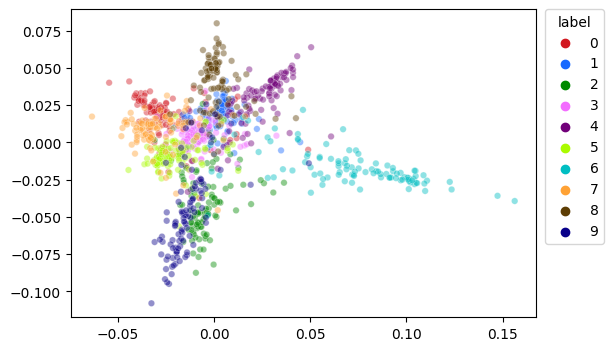

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.597, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.22740203717743773, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.16013333333333332, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.30246000000000006, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.4134066666666667, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 1.61 s (started: 2022-11-20 15:18:30 -08:00)


In [18]:
eigsh_jitter.run("s1k")["evaluations"]

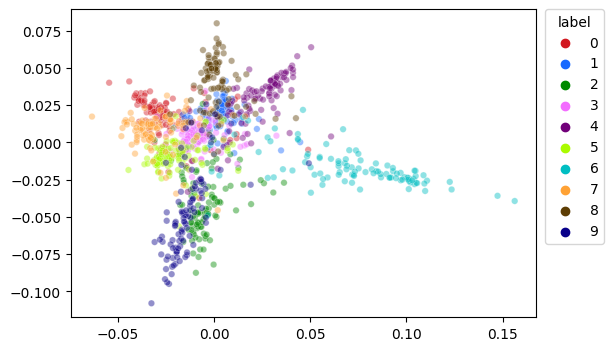

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.597, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.22740203717743773, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.16013333333333332, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.30246000000000006, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.4134066666666667, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 2.6 s (started: 2022-11-20 15:18:51 -08:00)


In [19]:
eigsh_no_jitter.run("s1k")["evaluations"]

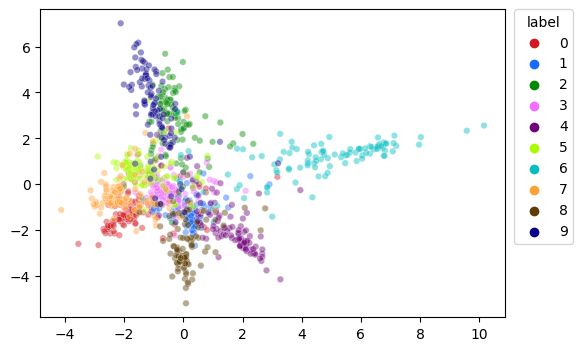

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.597, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.22740368345626533, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.16006666666666666, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.30248, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.4134333333333333, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 2.07 s (started: 2022-11-20 15:18:53 -08:00)


In [20]:
tsvdw_jitter.run("s1k")["evaluations"]

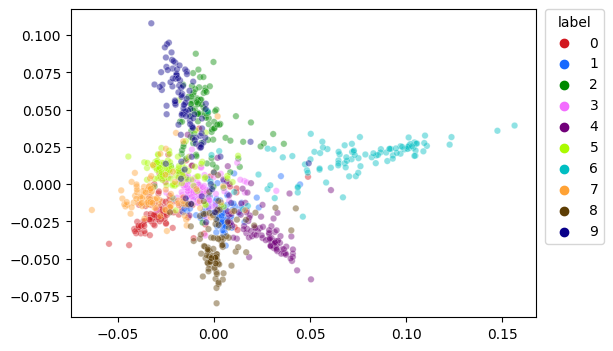

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.597, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.22740295027552931, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.16013333333333332, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.30246000000000006, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.41342, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 1.75 s (started: 2022-11-20 15:18:55 -08:00)


In [21]:
tsvdw_no_jitter.run("s1k")["evaluations"]

### MNIST

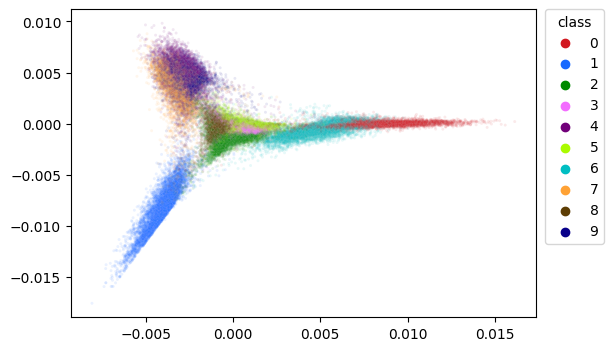

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5896571428571429, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.21972156344369886, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.015362857142857143, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.032008571428571435, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.062067047619047626, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 16.8 s (started: 2022-11-20 15:22:06 -08:00)


In [22]:
eigsh_jitter.run("mnist")["evaluations"]

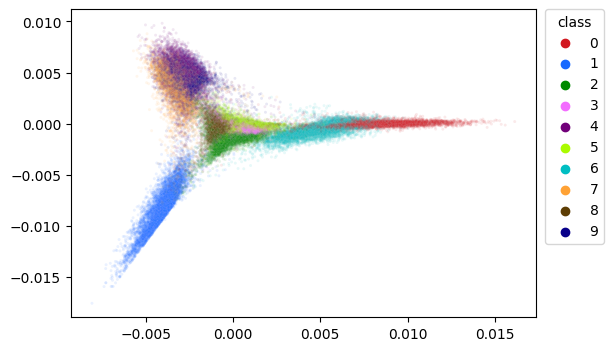

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5896571428571429, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.21972156344369886, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.015362857142857143, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.032008571428571435, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.062067047619047626, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 16 s (started: 2022-11-20 15:22:23 -08:00)


In [23]:
eigsh_no_jitter.run("mnist")["evaluations"]

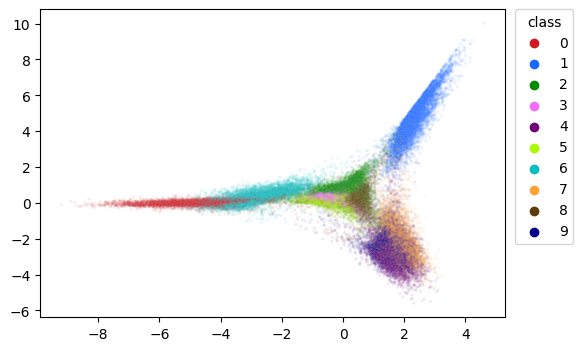

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5896428571428571, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.21970739544929152, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.015395238095238096, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.03199114285714286, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.06203257142857142, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 9.61 s (started: 2022-11-20 15:22:39 -08:00)


In [24]:
tsvdw_jitter.run("mnist")["evaluations"]

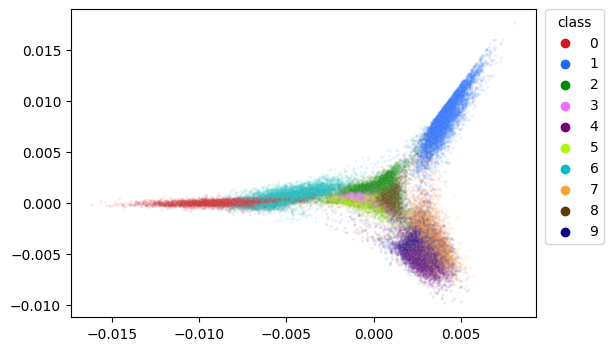

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5896457142857142, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.21970771452164678, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.015391428571428573, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.03200000000000001, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.06203885714285713, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 10.4 s (started: 2022-11-20 15:22:49 -08:00)


In [25]:
tsvdw_no_jitter.run("mnist")["evaluations"]

### mammoth

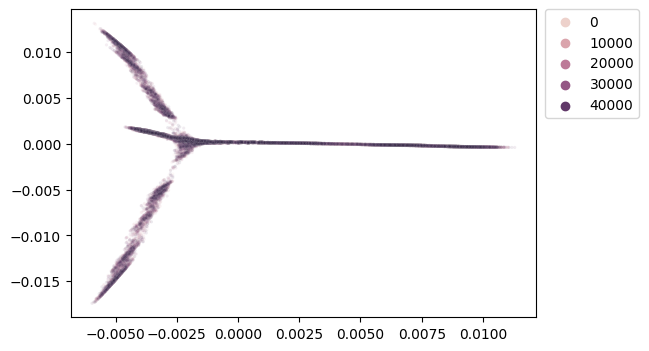

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.7781040000000001, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.6498398756725899, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.07480133333333332, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.10638280000000003, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.15219200000000002, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 1min 49s (started: 2022-11-20 15:22:59 -08:00)


In [26]:
eigsh_jitter.run("mammoth")["evaluations"]

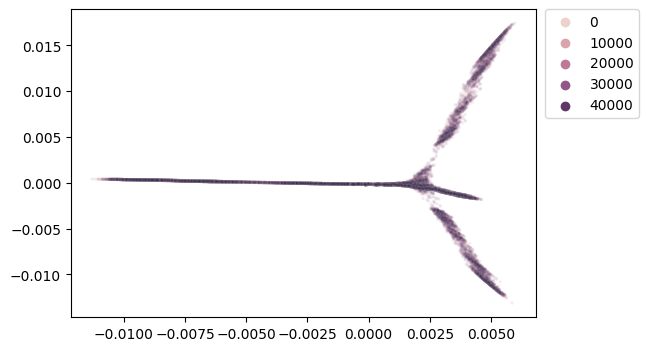

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.7781040000000001, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.6498401311580847, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.07478933333333333, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.10637200000000001, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.152196, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 1min 48s (started: 2022-11-20 15:24:48 -08:00)


In [27]:
eigsh_no_jitter.run("mammoth")["evaluations"]

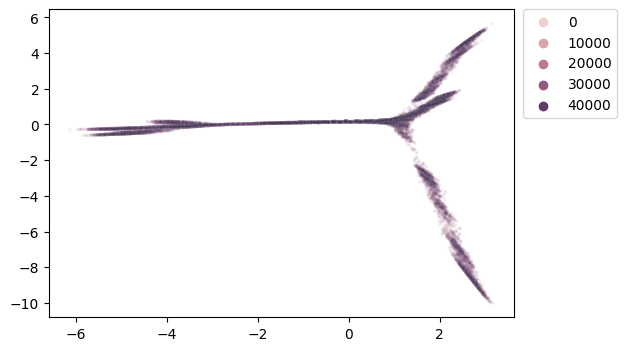

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.7809440000000001, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.6420848437237494, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.082704, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.11705480000000001, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.17069866666666664, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 16.9 s (started: 2022-11-20 15:26:36 -08:00)


In [28]:
tsvdw_jitter.run("mammoth")["evaluations"]

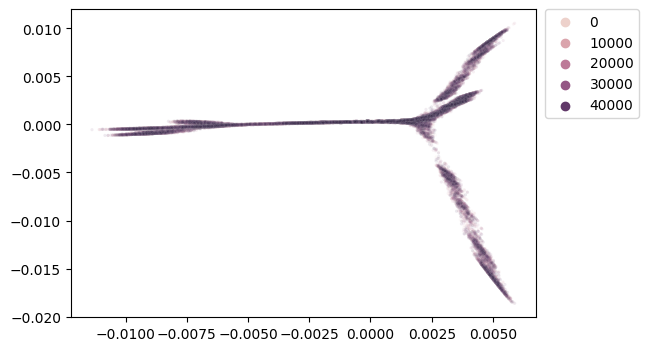

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.78096, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.6420847160618253, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.082676, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.11705760000000003, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.17070479999999996, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 17.4 s (started: 2022-11-20 15:26:53 -08:00)


In [29]:
tsvdw_no_jitter.run("mammoth")["evaluations"]